In [10]:
__author__ = 'ORI'

from matplotlib.collections import LineCollection

import numpy as np
import scipy.io
import sys, os
import matplotlib.pyplot as plt
# I should learn how to load libraries in a more elegant way



sys.path.append(r'C:\Users\ORI\Documents\IDC-non-sync\Thesis\PythonApplication1\OriKerasExtension')
#import OriKerasExtension
import ThesisHelper
#reload(OriKerasExtension)
reload(ThesisHelper)
from   ThesisHelper import LoadSingleSubjectPython, readCompleteMatFile, ExtractDataVer4
import P300Prediction
reload(P300Prediction)
from P300Prediction import accuracy_by_repetition, create_target_table


sys.path.append(r'C:\Users\ORI\Documents\IDC-non-sync\Thesis\PythonApplication1\OriKerasExtension')
#import OriKerasExtension
import ThesisHelper
from sklearn.metrics import roc_curve, auc, roc_auc_score
import P300Prediction
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from scipy import stats
from sklearn.cross_validation import StratifiedShuffleSplit

#reload(OriKerasExtension)
reload(ThesisHelper)
from ThesisHelper import LoadSingleSubjectPython, readCompleteMatFile, ExtractDataVer4
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

reload(P300Prediction)
from P300Prediction import accuracy_by_repetition, create_target_table


# [all_target, all_non_target] = LoadSingleSubjectPython(r'C:\Users\ORI\Documents\Thesis\dataset_all\RSVP_Color116msVPfat.mat')



# all_samples = np.vstack((all_target,all_non_target))


# '''
# Create the tagging column
# '''
# all_tags = np.vstack((np.ones((all_target.shape[0],1)), np.zeros((all_non_target.shape[0],1))))



# from OriKerasExtension.OriKerasExtension import DebugLSTM
import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from  keras.regularizers import WeightRegularizer

'''
define the neural network model:
'''


def create_compile_cnn_model():
    model = Sequential()

    number_of_time_stamps = 20
    number_of_out_channels = 10
    number_of_in_channels = 55
    length_of_time_axe_mask = 10

    model.add(Convolution2D(nb_filter=10,
                            nb_col=number_of_out_channels,
                            nb_row=1,
                            input_shape=(1, number_of_time_stamps, number_of_in_channels),
                            border_mode='same',
                            init='glorot_normal'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1, number_of_in_channels)))
    model.add(
        Convolution2D(nb_filter=number_of_out_channels, nb_row=6, nb_col=1, border_mode='same', init='glorot_normal'))
    model.add(MaxPooling2D(pool_size=(20, 1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd')
    return model

def create_compile_lstm_model():

    '''
    define the neural network model:
    '''
    model_lstm = Sequential()

    model_lstm.add(LSTM(input_dim=55, output_dim=20,return_sequences=True))
    model_lstm.add(Dropout(0.3))
    model_lstm.add(LSTM(input_dim=20, output_dim=20,return_sequences=False))
    model_lstm.add(Dense(2, W_regularizer=l2(0.06)))
    model_lstm.add(Activation('softmax'))
    model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model_lstm


def create_compile_lstm_model_letter():

    '''
    define the neural network model:
    '''
    model_lstm = Sequential()

    model_lstm.add(LSTM(input_dim=55, output_dim=20,return_sequences=True))
#     model_lstm.add(Dropout(0.01))
    model_lstm.add(LSTM(input_dim=20, output_dim=20,return_sequences=True))
#     model_lstm.add(Dropout(0.01))
    model_lstm.add(LSTM(input_dim=20, output_dim=20,return_sequences=False))
    model_lstm.add(Dense(31, W_regularizer=l2(0.0006)))
    model_lstm.add(Activation('softmax'))
    model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model_lstm



def create_compile_dense_model():

    '''
    define the neural network model:
    '''
    model_lstm = Sequential()
    model_lstm.add(keras.layers.core.Flatten(input_shape=(55,100)))
    model_lstm.add(Dense(input_dim=55*100, output_dim=30 , W_regularizer=l2(0.06)))
    model_lstm.add(Activation('tanh'))
    model_lstm.add(Dense(2))
    model_lstm.add(Activation('softmax'))
    model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model_lstm

def create_small_compile_dense_model():

    '''
    define the neural network model:
    '''
    model_lstm = Sequential()
    model_lstm.add(keras.layers.core.Flatten(input_shape=(55,25)))
    model_lstm.add(Dense(input_dim=55*25, output_dim=20 ))
    model_lstm.add(Dropout(0.3))
    model_lstm.add(Activation('tanh'))
    model_lstm.add(Dense(output_dim=20 , W_regularizer=l2(0.06)))
    model_lstm.add(Activation('tanh'))
    model_lstm.add(Dense(2))
    model_lstm.add(Activation('softmax'))
    model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop')

    return model_lstm


# def down_sample_data()




In [8]:
def create_evaluation_data(gcd_res, down_samples_param):
#     gcd_res = readCompleteMatFile(file_name)
    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'], gcd_res['target'],
                                    -200, 800)
    # print  data_for_eval

    temp_data_for_eval = downsample_data(data_for_eval[0], data_for_eval[0].shape[1], down_samples_param)

    test_data_gcd, test_target_gcd = temp_data_for_eval[gcd_res['train_mode'] != 1], data_for_eval[1][
        gcd_res['train_mode'] != 1]
    return test_data_gcd, test_target_gcd


def downsample_data(data, number_of_original_samples, down_samples_param):


    new_number_of_time_stamps = number_of_original_samples / down_samples_param


    # print  data_for_eval
    temp_data_for_eval = np.zeros((data.shape[0], new_number_of_time_stamps, data.shape[2]))

    for new_i, i in enumerate(range(0, number_of_original_samples, down_samples_param)):
        temp_data_for_eval[:, new_i, :] = np.mean(data[:, range(i, (i + down_samples_param)), :], axis=1)
    return temp_data_for_eval


def create_train_data(gcd_res, down_samples_param):
    all_positive_train = []
    all_negative_train = []

    last_time_stamp = 800
    fist_time_stamp = -200


    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'],
                                    gcd_res['target'], fist_time_stamp, last_time_stamp)
    
    print data_for_eval[0].shape
    temp_data_for_eval = downsample_data(data_for_eval[0],data_for_eval[0].shape[1], down_samples_param)

    all_data = temp_data_for_eval[np.all([gcd_res['train_mode'] != 3], axis=0)]
    categorical_tags = to_categorical(gcd_res['stimulus'][gcd_res['train_mode'] != 3])
    indexes = range(len(categorical_tags))
    print "len(categorical_tags) {0}".format(len(categorical_tags))

    shuffeled_samples, suffule_tags = (all_data, categorical_tags)
    return shuffeled_samples, suffule_tags

def create_letter_test_data(gcd_res, down_samples_param):
    all_positive_train = []
    all_negative_train = []

    last_time_stamp = 800
    fist_time_stamp = -200


    data_for_eval = ExtractDataVer4(gcd_res['all_relevant_channels'], gcd_res['marker_positions'],
                                    gcd_res['target'], fist_time_stamp, last_time_stamp)
    
    print data_for_eval[0].shape
    temp_data_for_eval = downsample_data(data_for_eval[0],data_for_eval[0].shape[1], down_samples_param)

    all_data = temp_data_for_eval[np.all([gcd_res['train_mode'] == 3], axis=0)]
    categorical_tags = to_categorical(gcd_res['stimulus'][gcd_res['train_mode'] == 3])
    indexes = range(len(categorical_tags))
    print "len(categorical_tags) {0}".format(len(categorical_tags))

    shuffeled_samples, suffule_tags = (all_data, categorical_tags)
    return shuffeled_samples, suffule_tags


def create_data_for_compare_by_repetition(file_name):
    gcd_res = readCompleteMatFile(file_name)
    sub_gcd_res = dict(train_trial=gcd_res['train_trial'][gcd_res['train_mode'] != 1],
                       train_block=gcd_res['train_block'][gcd_res['train_mode'] != 1],
                       stimulus=gcd_res['stimulus'][gcd_res['train_mode'] != 1])
    return sub_gcd_res

#shuffeled_samples, suffule_tags = create_train_data(file_name=None, down_samples_param=5)
# shuffeled_samples, suffule_tags = create_train_data(file_name=None, down_samples_param=20)
# original_weights_mlp = model_mlp.get_weights()

data_set_locations = ["RSVP_Color116msVPicr.mat",
                      "RSVP_Color116msVPpia.mat",
                      "RSVP_Color116msVPfat.mat",
                      "RSVP_Color116msVPgcb.mat",
                      "RSVP_Color116msVPgcc.mat",
                      "RSVP_Color116msVPgcd.mat",
                      "RSVP_Color116msVPgcf.mat",
                      "RSVP_Color116msVPgcg.mat",
                      "RSVP_Color116msVPgch.mat",
                      "RSVP_Color116msVPiay.mat",
                      "RSVP_Color116msVPicn.mat"];

# data_set_locations = ["RSVP_Color116msVPgcd.mat"]

# results = []

# for subject_name in data_set_locations:
#     file_name = r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format(subject_name)
#     gcd_res = readCompleteMatFile(file_name)

def print_true_vs_predict(true_val, predicted_val):
    import matplotlib.cm as cm        
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(true_val[:,1].reshape(-1,30), cmap=cm.Greys_r, interpolation='none', aspect='auto')
    plt.subplot(1,2,2)
    plt.imshow(predicted_val[:,1].reshape(-1,30), cmap=cm.Greys_r, interpolation='none', aspect='auto')
    plt.show()

# def calculate_proximity_to_target()

In [10]:
gcd_res = readCompleteMatFile(r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format("RSVP_Color116msVPicr.mat"))
gcd_res.keys()
to_categorical(gcd_res['stimulus'])
create_train_data(gcd_res,8)

(18600L, 200L, 55L)
len(categorical_tags) 7200


(array([[[  428.875,   146.625,   -57.5  , ...,   618.   ,  -366.875,
           -458.875],
         [  352.375,    95.75 ,  -149.25 , ...,   658.75 ,  -275.125,
           -351.875],
         [  514.125,   228.125,    13.75 , ...,   569.75 ,  -318.5  ,
           -425.625],
         ..., 
         [  935.5  ,   671.625,   440.125, ...,   525.   ,  -352.625,
           -597.25 ],
         [  948.   ,   701.125,   447.   , ...,   475.25 ,  -473.125,
           -711.75 ],
         [ 1068.875,   829.5  ,   591.375, ...,   530.   ,  -540.125,
           -746.625]],
 
        [[  551.875,   302.25 ,    66.625, ...,   541.875,  -485.875,  -521.   ],
         [  752.125,   510.75 ,   280.5  , ...,   636.   ,  -275.375,
           -384.375],
         [  827.375,   575.875,   342.25 , ...,   672.   ,  -319.125,
           -499.25 ],
         ..., 
         [ 1240.625,  1018.125,   763.5  , ...,   315.75 ,  -658.5  ,  -777.   ],
         [ 1031.75 ,   784.125,   548.   , ...,   258.5  ,  -774.5 

In [11]:
model = create_compile_lstm_model_letter()
# model_mlp = create_small_compile_dense_model()
original_weights = model.get_weights()
# original_weights_mlp = model_mlp.get_weights()


In [12]:
%matplotlib inline
results = []
for subject_name in data_set_locations:
    file_name = r'C:\Users\ORI\Documents\Thesis\dataset_all\{0}'.format(subject_name)
    gcd_res = readCompleteMatFile(file_name)
    subject_results = dict()
    for i in range(1):
        model.set_weights(original_weights)
#         model_mlp.set_weights(original_weights_mlp)
        down_sample_param = 8
        train_data, train_tags = create_train_data(gcd_res, down_samples_param=down_sample_param)
        print train_tags.shape
        
#         target_location = np.where(np.all([gcd_res['train_mode'] == 1,gcd_res['target'] == 1 ], axis = 0))[0]
#         non_target_location = np.where(np.all([gcd_res['train_mode'] == 1 ], axis = 0))[0]
        # np.abs(non_target_location - 13).argmin()
#         print target_location[0]
#         print len(target_location)
#         distance_from_target =  np.zeros((len(target_location), len(non_target_location)))
#         for i, item in enumerate(target_location) :
#             distance_from_target[i,:] = non_target_location - item
            

#         minimal_distance_from_target = np.zeros_like(non_target_location)
#         for i, item in enumerate(np.abs(distance_from_target).argmin(axis=0).astype(np.int)) :
#             minimal_distance_from_target[i] =  non_target_location[i] - target_location[item]
    
        
        
        
        shuffeled_samples, suffule_tags = shuffle(train_data, train_tags, random_state=0)
        
        
        test_data, test_tags = create_letter_test_data(gcd_res, down_samples_param=down_sample_param)
        
        
        
        for epoch_i in range(1):
            model.fit(stats.zscore(shuffeled_samples, axis=1), suffule_tags,
                      nb_epoch=400, show_accuracy=True, verbose=1,validation_data=(stats.zscore(test_data, axis=1), test_tags))
            
            
            
# #             predicted_res = model.predict(stats.zscore(train_data, axis=1))
# #             print train_data.shape
            
# #             print_true_vs_predict(train_tags, predicted_res)
# #             print distance_from_target.shape
# #             print predicted_res.shape
# #             plt.scatter(minimal_distance_from_target, predicted_res[:,1],alpha=0.1)
# #             hist_gaps = dict()
# #             for gaps_i, gap in enumerate(range(-30,31)):
# #                 hist_gaps[gaps_i] = predicted_res[:,1][minimal_distance_from_target == gap].sum()
# #             print hist_gaps
# #             plt.show()
#             test_data_gcd, test_target_gcd = create_evaluation_data(gcd_res, down_samples_param=down_sample_param)

#             test_prediction = model.predict(stats.zscore(test_data_gcd, axis=1), verbose=1)
#             test_prediction_mlp = model_mlp.predict(stats.zscore(test_data_gcd, axis=1), verbose=1)
            

# #             x, y, _ = roc_curve(test_target_gcd, test_prediction[:, 1])
# #             x_mlp, y_mlp, _ = roc_curve(test_target_gcd, test_prediction_mlp[:, 1])
            
            
#             # This is the ROC curve
#             # plt.plot(x, y)
            
            
#             # plt.show()
            
            
            
#             auc_score = roc_auc_score(test_target_gcd, test_prediction[:, 1])
#             auc_score_mlp = roc_auc_score(test_target_gcd, test_prediction_mlp[:, 1])
#             print "auc_score:{0}".format(auc_score)
#             sub_gcd_res = create_data_for_compare_by_repetition(file_name)
#             # sub_gcd_res = dict(train_trial=gcd_res['train_trial'][gcd_res['train_mode'] != 1],
#             # train_block=gcd_res['train_block'][gcd_res['train_mode'] != 1],
#             # stimulus=gcd_res['stimulus'][gcd_res['train_mode'] != 1])

#             _, _, gt_data_for_sum = create_target_table(sub_gcd_res, test_target_gcd)
#             _, _, actual_data_for_sum = create_target_table(sub_gcd_res, test_prediction[:, 1])
#             _, _, actual_data_for_sum_mlp = create_target_table(sub_gcd_res, test_prediction_mlp[:, 1])
#             subject_results[i] = dict(test_prediction=test_prediction, 
#                                       auc_score=auc_score,
#                                       acc_by_rep=accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=10))

#             print "accuracy_by_repetition {0}".format(
#                 accuracy_by_repetition(actual_data_for_sum, gt_data_for_sum, number_of_repetition=10))
            
#             print "accuracy_by_repetition_mlp {0}".format(
#                 accuracy_by_repetition(actual_data_for_sum_mlp, gt_data_for_sum, number_of_repetition=10))

            
            

    

        



                
    break
    results.append(dict(subject_name=subject_name, subject_results=subject_results))


(18600L, 200L, 55L)
len(categorical_tags) 13200
(13200L, 31L)
(18600L, 200L, 55L)
len(categorical_tags) 5400
Train on 13200 samples, validate on 5400 samples
Epoch 1/400
13200/13200 [==============================] - 33s - loss: 3.4424 - acc: 0.0345 - val_loss: 3.4206 - val_acc: 0.0320
Epoch 2/400
13200/13200 [==============================] - 32s - loss: 3.4212 - acc: 0.0359 - val_loss: 3.4081 - val_acc: 0.0350
Epoch 3/400
13200/13200 [==============================] - 32s - loss: 3.4076 - acc: 0.0427 - val_loss: 3.3970 - val_acc: 0.0385
Epoch 4/400
13200/13200 [==============================] - 33s - loss: 3.3955 - acc: 0.0468 - val_loss: 3.3906 - val_acc: 0.0367
Epoch 5/400
13200/13200 [==============================] - 32s - loss: 3.3851 - acc: 0.0504 - val_loss: 3.3850 - val_acc: 0.0415
Epoch 6/400
13200/13200 [==============================] - 32s - loss: 3.3729 - acc: 0.0533 - val_loss: 3.3809 - val_acc: 0.0441
Epoch 7/400
13200/13200 [==============================] - 32s - los

In [27]:
from sklearn.metrics import confusion_matrix
validation_data=(stats.zscore(test_data, axis=1), test_tags)
prediction_res = model.predict(stats.zscore(test_data, axis=1))
print to_categorical(prediction_res.max(axis=1)).shape
test_tags.shape
confusion_matrix(test_tags, to_categorical(prediction_res.argmax(axis=1)))

(5400L, 1L)


ValueError: Found arrays with inconsistent numbers of samples: [  31 5400]

In [44]:
import pandas as pd
confusion_matrix(test_tags.argmax(axis=1), prediction_res.argmax(axis=1))
ABC_list = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','-','.','!','<']
df = pd.DataFrame(confusion_matrix(test_tags.argmax(axis=1), prediction_res.argmax(axis=1)), columns=ABC_list, index=ABC_list)
# df.set_index(ABC_list)
df.to_excel(r'c:\temp\letters.xls')

In [49]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(ABC_list))
    plt.xticks(tick_marks, ABC_list, rotation=45)
    plt.yticks(tick_marks, ABC_list)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

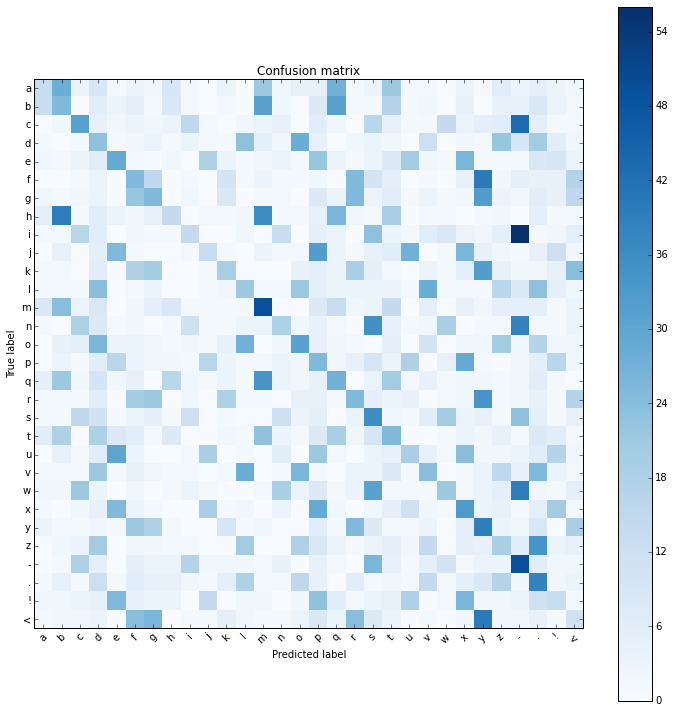

In [53]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(confusion_matrix(test_tags.argmax(axis=1), prediction_res.argmax(axis=1)))
    
    
    

In [ ]:
-.!<